# Workflow

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import sys

sys.path.append('../hydra_TOD/')

from astropy.coordinates import EarthLocation, AltAz, SkyCoord
from astropy.time import Time, TimeDelta
import astropy.units as u
from utils import Leg_poly_proj, view_samples
from flicker_model import sim_noise, flicker_cov
from simulation import * 

## A. Simulation

In [2]:
nside = 64

### 1. Define the two scans (rising and setting)
Tsky parameters and operators

In [3]:
# Get the timestream of beam centers (theta_c, phi_c) for each scan
t_list, theta_c_setting, phi_c_setting = sim_MeerKAT_scan(elevation=41.5, az_s=-60.3, az_e=-42.3, start_time_utc="2019-04-23 20:41:56.397")
bool_map_setting, integrated_beam_setting = stacked_beam_map(theta_c_setting, 
                                       phi_c_setting, 
                                       FWHM=1.1, 
                                       NSIDE=nside, 
                                       threshold = 0.0111) # This threshold cut off the beam directions outside the 3sigma region.

In [4]:
full_bool_map = bool_map_setting
pixel_indices = np.where(full_bool_map)[0]
integrated_beam = integrated_beam_setting 

Tsky_operator_setting = generate_Tsky_proj(full_bool_map, theta_c_setting, phi_c_setting, FWHM=1.1)

In [5]:
def sky_vector(pixel_indices, freq, Nside=64, sky_model=None):
    if sky_model is None:
        from pygdsm import GlobalSkyModel
        gsm = GlobalSkyModel()
        skymap = gsm.generate(freq)
    else:
        skymap = sky_model(freq)
    skymap = hp.ud_grade(skymap, nside_out=Nside)
    ptsrc = np.load("gleam_nside512_K_allsky_408MHz.npy")
    ptsrc_map = hp.ud_grade(ptsrc, nside_out=Nside)
    skymap = skymap + ptsrc_map
    return skymap[pixel_indices]

sky_params = sky_vector(pixel_indices, 408, Nside=nside, sky_model=None)
print("Number of pixels: ", len(pixel_indices))

Number of pixels:  375


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

gain_samples, Tsky_samples, rec_samples, Tsky_proj

# Generate reconstructed TODs from samples
tod_preds = np.array([model(TOD_samples, gain_samples, Tsky_samples, rec_samples, Tsky_proj) 
                    for i in range(1000)])  # shape: (N_samples, N_time)

# Compute statistics over samples
mean_tod = np.mean(tod_preds, axis=0)
lower_1sigma = np.percentile(tod_preds, 16, axis=0)
upper_1sigma = np.percentile(tod_preds, 84, axis=0)

lower_2sigma = np.percentile(tod_preds, 2.5, axis=0)
upper_2sigma = np.percentile(tod_preds, 97.5, axis=0)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(t, tod_obs, label='Observed TOD', color='black', lw=1.5)
plt.plot(t, mean_tod, label='Mean Model', color='blue', lw=2)

# 68% CI
plt.fill_between(t, lower_1sigma, upper_1sigma, color='blue', alpha=0.3, label='68% CI')

# 95% CI
plt.fill_between(t, lower_2sigma, upper_2sigma, color='blue', alpha=0.15, label='95% CI')

plt.xlabel('Time / Frequency / Channel index')
plt.ylabel('Signal')
plt.legend()
plt.title('TOD Reconstruction with Posterior Samples')
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'samples' is not defined

### 2. Define Tdiode and Trec

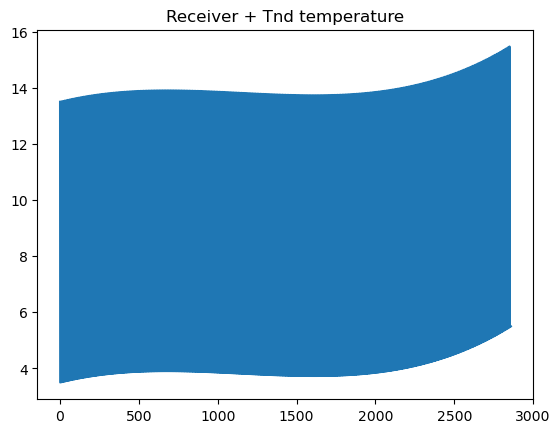

In [6]:
# generate a vector of length ntime, every 10 elements there is a 1, the rest is 0
def generate_vector(ntime):
    vector = np.zeros(ntime)
    for i in range(0, ntime, 10):
        vector[i] = 1
    return vector

ntime = len(t_list)
ndiode_proj = generate_vector(ntime)

nd_rec_operator = np.zeros((ntime, 5))
nd_rec_operator[:, 0] = ndiode_proj    # The noise diode part
nd_rec_operator[:, 1:] = Leg_poly_proj(4, t_list) # The Legendre polynomial (receiver temperature and all) part

T_ndiode = 10.0
rec_params=np.array([4, 0.5, 0.5, 0.5]) # The receiver temperature and all
nd_rec_params = np.zeros(5)
nd_rec_params[0] = T_ndiode
nd_rec_params[1:] = rec_params

plt.title("Receiver + Tnd temperature")
plt.plot(nd_rec_operator @ nd_rec_params)

### 3. Define Gain and Noise

In [7]:
gain_proj = Leg_poly_proj(4, t_list)

#gain_params_setting = np.random.uniform(low=0.0, high=1.0, size=4) + np.array([6., 0., 0., 0.])
gain_params_setting = np.array([6.31194264, 0.42038942, 0.264222, 0.05578821])

gains_setting = gain_proj @ gain_params_setting
print(gain_params_setting)
# save the gain parameters
# np.savez('outputs/GS1/gain_params.npy', gain_params_setting)

[6.31194264 0.42038942 0.264222   0.05578821]


In [8]:
dtime = 2
fc = (1/ntime/dtime)*2*np.pi
logfc = np.log10(fc)
alpha = 2.0
logf0_list=[-4.874571109426952, -3.874259892646189, -2.901434432609383] 
# Corresponding to knee frequencies: 0.001. 0.01, 0.1
sigma_2 = 1/(4e5)

f0 = 10**logf0_list[0]

noise_setting = sim_noise(f0, fc, alpha, t_list, white_n_variance=sigma_2)

In [9]:
Tsys_setting = Tsky_operator_setting @ sky_params + nd_rec_operator @ nd_rec_params 
TOD_setting = Tsys_setting * (1+noise_setting) * gains_setting

## B. Sampling

In [10]:
# Convert theta/phi coordinates to HEALPix pixels
pixels_c_setting = [hp.ang2pix(nside=nside, theta=theta, phi=phi)
          for theta, phi in zip(theta_c_setting, phi_c_setting)]
bool_map_c_setting = np.zeros(hp.nside2npix(nside))
bool_map_c_setting[pixels_c_setting] = 1

In [11]:
# For a 1D array 'integrated_beam_setting'
n_cal_pixs=1
top_20_beam_indices = np.argpartition(integrated_beam_setting[pixel_indices], -20)[-20:]
top_n_sky_indices = np.argpartition(sky_params[top_20_beam_indices], -n_cal_pixs)[-n_cal_pixs:]
calibration_indices = top_20_beam_indices[top_n_sky_indices]

In [12]:
init_Tsys_params = np.hstack([sky_params, nd_rec_params])
init_noise_params = [-4.8, 2.2]

gain_prior_cov_inv = np.zeros(4)
# prior_std_frac = 1
# gain_prior_cov_inv = 1. / (prior_std_frac * gain_params_setting)**2  # Prior STD ~100%
gain_prior_cov_inv[0] = 2.51 # DC mode: Prior STD ~10%
gain_prior_mean = gain_params_setting

prior_std_frac = 0.1
Tsky_prior_cov_inv = 1. / (prior_std_frac * sky_params)**2
Tsky_prior_cov_inv[calibration_indices] = 1e20

aux = np.ones_like(nd_rec_params)*0.0
aux[0] = 1
Trec_prior_cov_inv = [aux] # Effectlively no prior

# logfc_c= np.log10(fc)
# def log_prior_noise(params):
#     _, logfc, _ = params
#     return -1e10 * (logfc_c - logfc)**4 # Effectively constrain f_c


In [13]:
from full_Gibbs_sampler import full_Gibbs_sampler_multi_TODS_v2

Tsys_samples, all_gain_samples, all_noise_samples = \
    full_Gibbs_sampler_multi_TODS_v2([TOD_setting],
                                    [t_list],
                                    [gain_proj],
                                    [Tsky_operator_setting],
                                    [nd_rec_operator],
                                    init_Tsys_params,
                                    init_noise_params, 
                                    [logfc],
                                    num_Jeffrey=False,
                                    wnoise_var=2.5e-6,
                                    Tsky_prior_cov_inv=Tsky_prior_cov_inv,
                                    Tsky_prior_mean=sky_params,
                                    local_Trec_prior_cov_inv_list=Trec_prior_cov_inv,
                                    local_Trec_prior_mean_list=[nd_rec_params],
                                    local_gain_prior_cov_inv_list=[gain_prior_cov_inv],
                                    local_gain_prior_mean_list=[gain_prior_mean],
                                    #local_noise_prior_func_list=[log_prior_noise, log_prior_noise],
                                    n_samples=1000,
                                    tol=1e-12,
                                    Est_mode=False)

Rank: 0, local id: 0, gain_sample 0: [6.31155705 0.4206357  0.26223667 0.05671781]
Rank: 0, local id: 0, noise_sample 0: [-4.72816572  3.52511304]
Reached max iterations with fractional norm error 0.00035855371671837904.
Rank: 0, local id: 0, gain_sample 1: [6.31172476 0.42048089 0.26268636 0.05678326]
Rank: 0, local id: 0, noise_sample 1: [-4.50913446  3.34539815]
Reached max iterations with fractional norm error 9.371554067378143e-05.
Rank: 0, local id: 0, gain_sample 2: [6.31188069 0.42125465 0.2639065  0.05653542]
Rank: 0, local id: 0, noise_sample 2: [-4.55324057  2.92695723]
Reached max iterations with fractional norm error 0.0017365201487616545.
Rank: 0, local id: 0, gain_sample 3: [6.31155277 0.42166153 0.26416082 0.05550297]
Rank: 0, local id: 0, noise_sample 3: [-5.57661258  1.93885933]
Reached max iterations with fractional norm error 0.002203165193591963.
Rank: 0, local id: 0, gain_sample 4: [6.3113591  0.42199374 0.26379005 0.05585742]
Rank: 0, local id: 0, noise_sample 4:

#### Visualize the Tsky samples

In [14]:
# Save the TOD simulation
np.save('outputs/GS1/TOD_setting.npy', TOD_setting)

In [15]:
# First, save the samples as npy files..

np.save("outputs/GS1/Tsys_samples.npy", Tsys_samples)
np.save("outputs/GS1/gain_samples.npy", np.concatenate(all_gain_samples, axis=0))
np.save("outputs/GS1/noise_samples.npy", np.concatenate(all_noise_samples, axis=0))

In [16]:
# Read the saved samples

Tsys_samples = np.load('outputs/GS1/Tsys_samples.npy')
gain_samples = np.load('outputs/GS1/gain_samples.npy')
noise_samples = np.load('outputs/GS1/noise_samples.npy')


In [17]:
gain_samples.shape

(1, 1000, 4)

In [18]:
num_pixels = len(pixel_indices)
Tsky_samples = Tsys_samples[:, :num_pixels]
other_samples = np.hstack((gain_samples[0], Tsys_samples[:, num_pixels:], noise_samples[0]))
Tmean = np.mean(Tsky_samples, axis=0)
Tstd = np.std(Tsky_samples, axis=0)
Tresidual = Tmean - sky_params


NPIX = hp.nside2npix(nside)

true_map = np.zeros(NPIX, dtype=float)
sample_mean_map = np.zeros(NPIX, dtype=float)
sample_std_map = np.zeros(NPIX, dtype=float)

true_map[pixel_indices] = sky_params
sample_mean_map[pixel_indices] = Tmean
sample_std_map[pixel_indices] = Tstd

The mean residual is:  -0.4167277487781347
16th percentile:  -0.6104131010395164
84th percentile:  0.3236844075052773


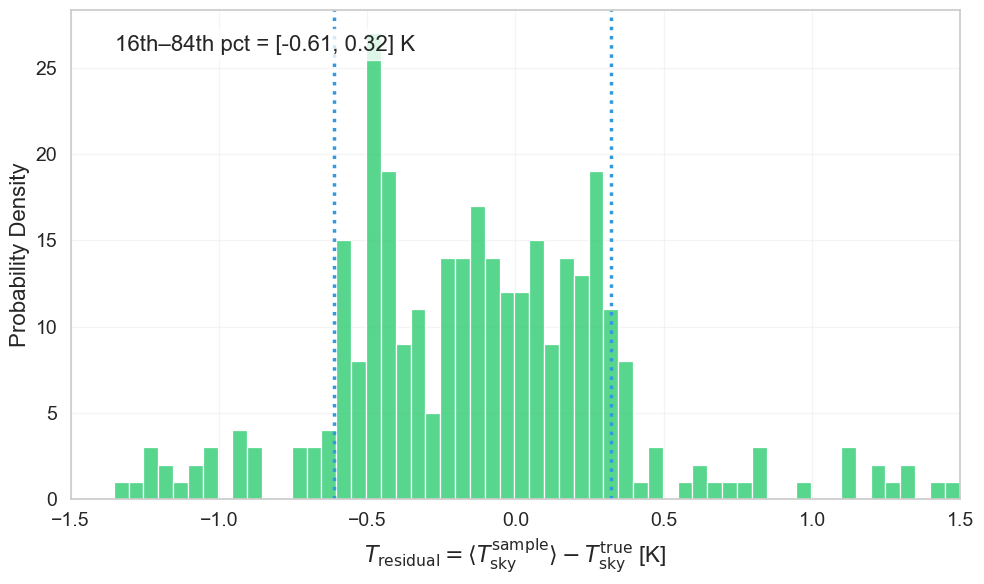

In [19]:
import seaborn as sns
import numpy as np
# Calculate residuals
residuals = Tmean - sky_params
from visualisation import plot_residual_histogram
plot_residual_histogram(residuals, save_path="./GS1_residuals_histogram.pdf")

# Caption:
# Figure: Distribution of residuals in the sky map estimate, defined as the difference between the mean of sampled sky estimates and the true sky signal. 
# The histogram shows the probability density of the residuals, overlaid with a kernel density estimate (KDE). The vertical dashed line indicates the mean residual (μ), 
# while the dotted lines mark the 16th and 84th percentiles, capturing the central 68% interval of the distribution.

In [20]:
truths = list(gain_params_setting) + [T_ndiode]+ list(rec_params) + [logf0_list[0], alpha]

Corner plot saved to ./GS1_corner_plot.pdf


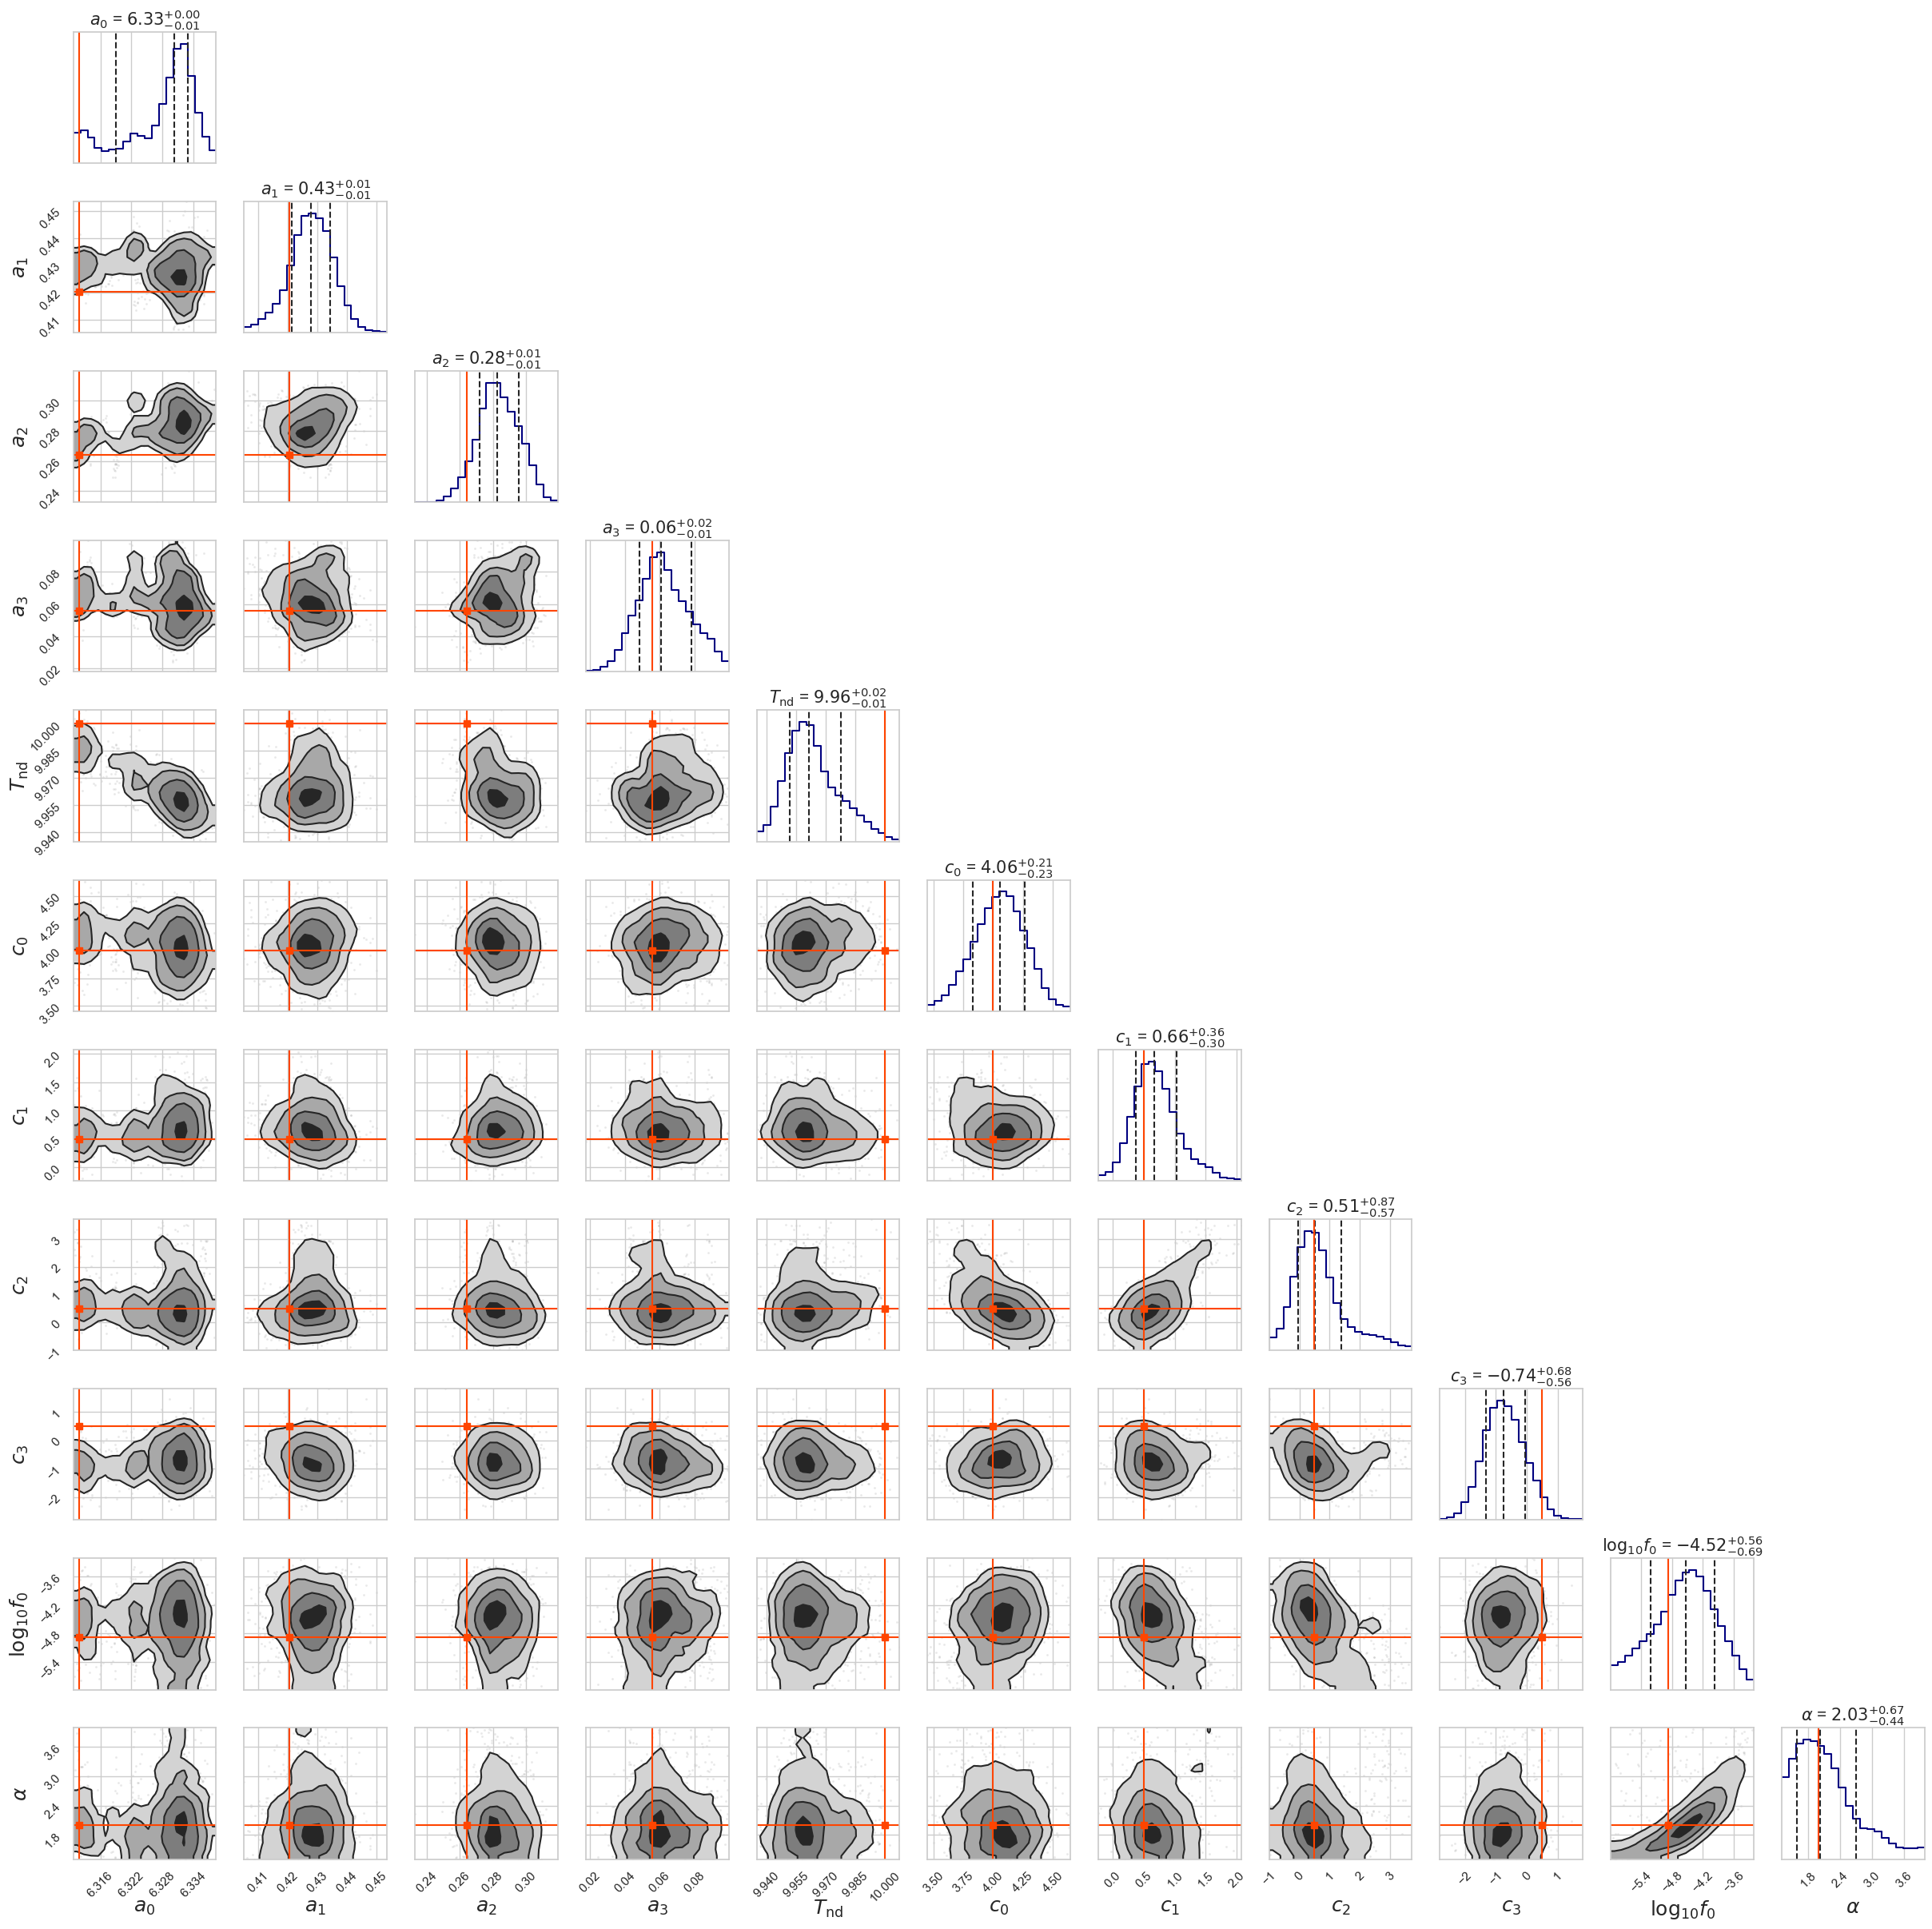

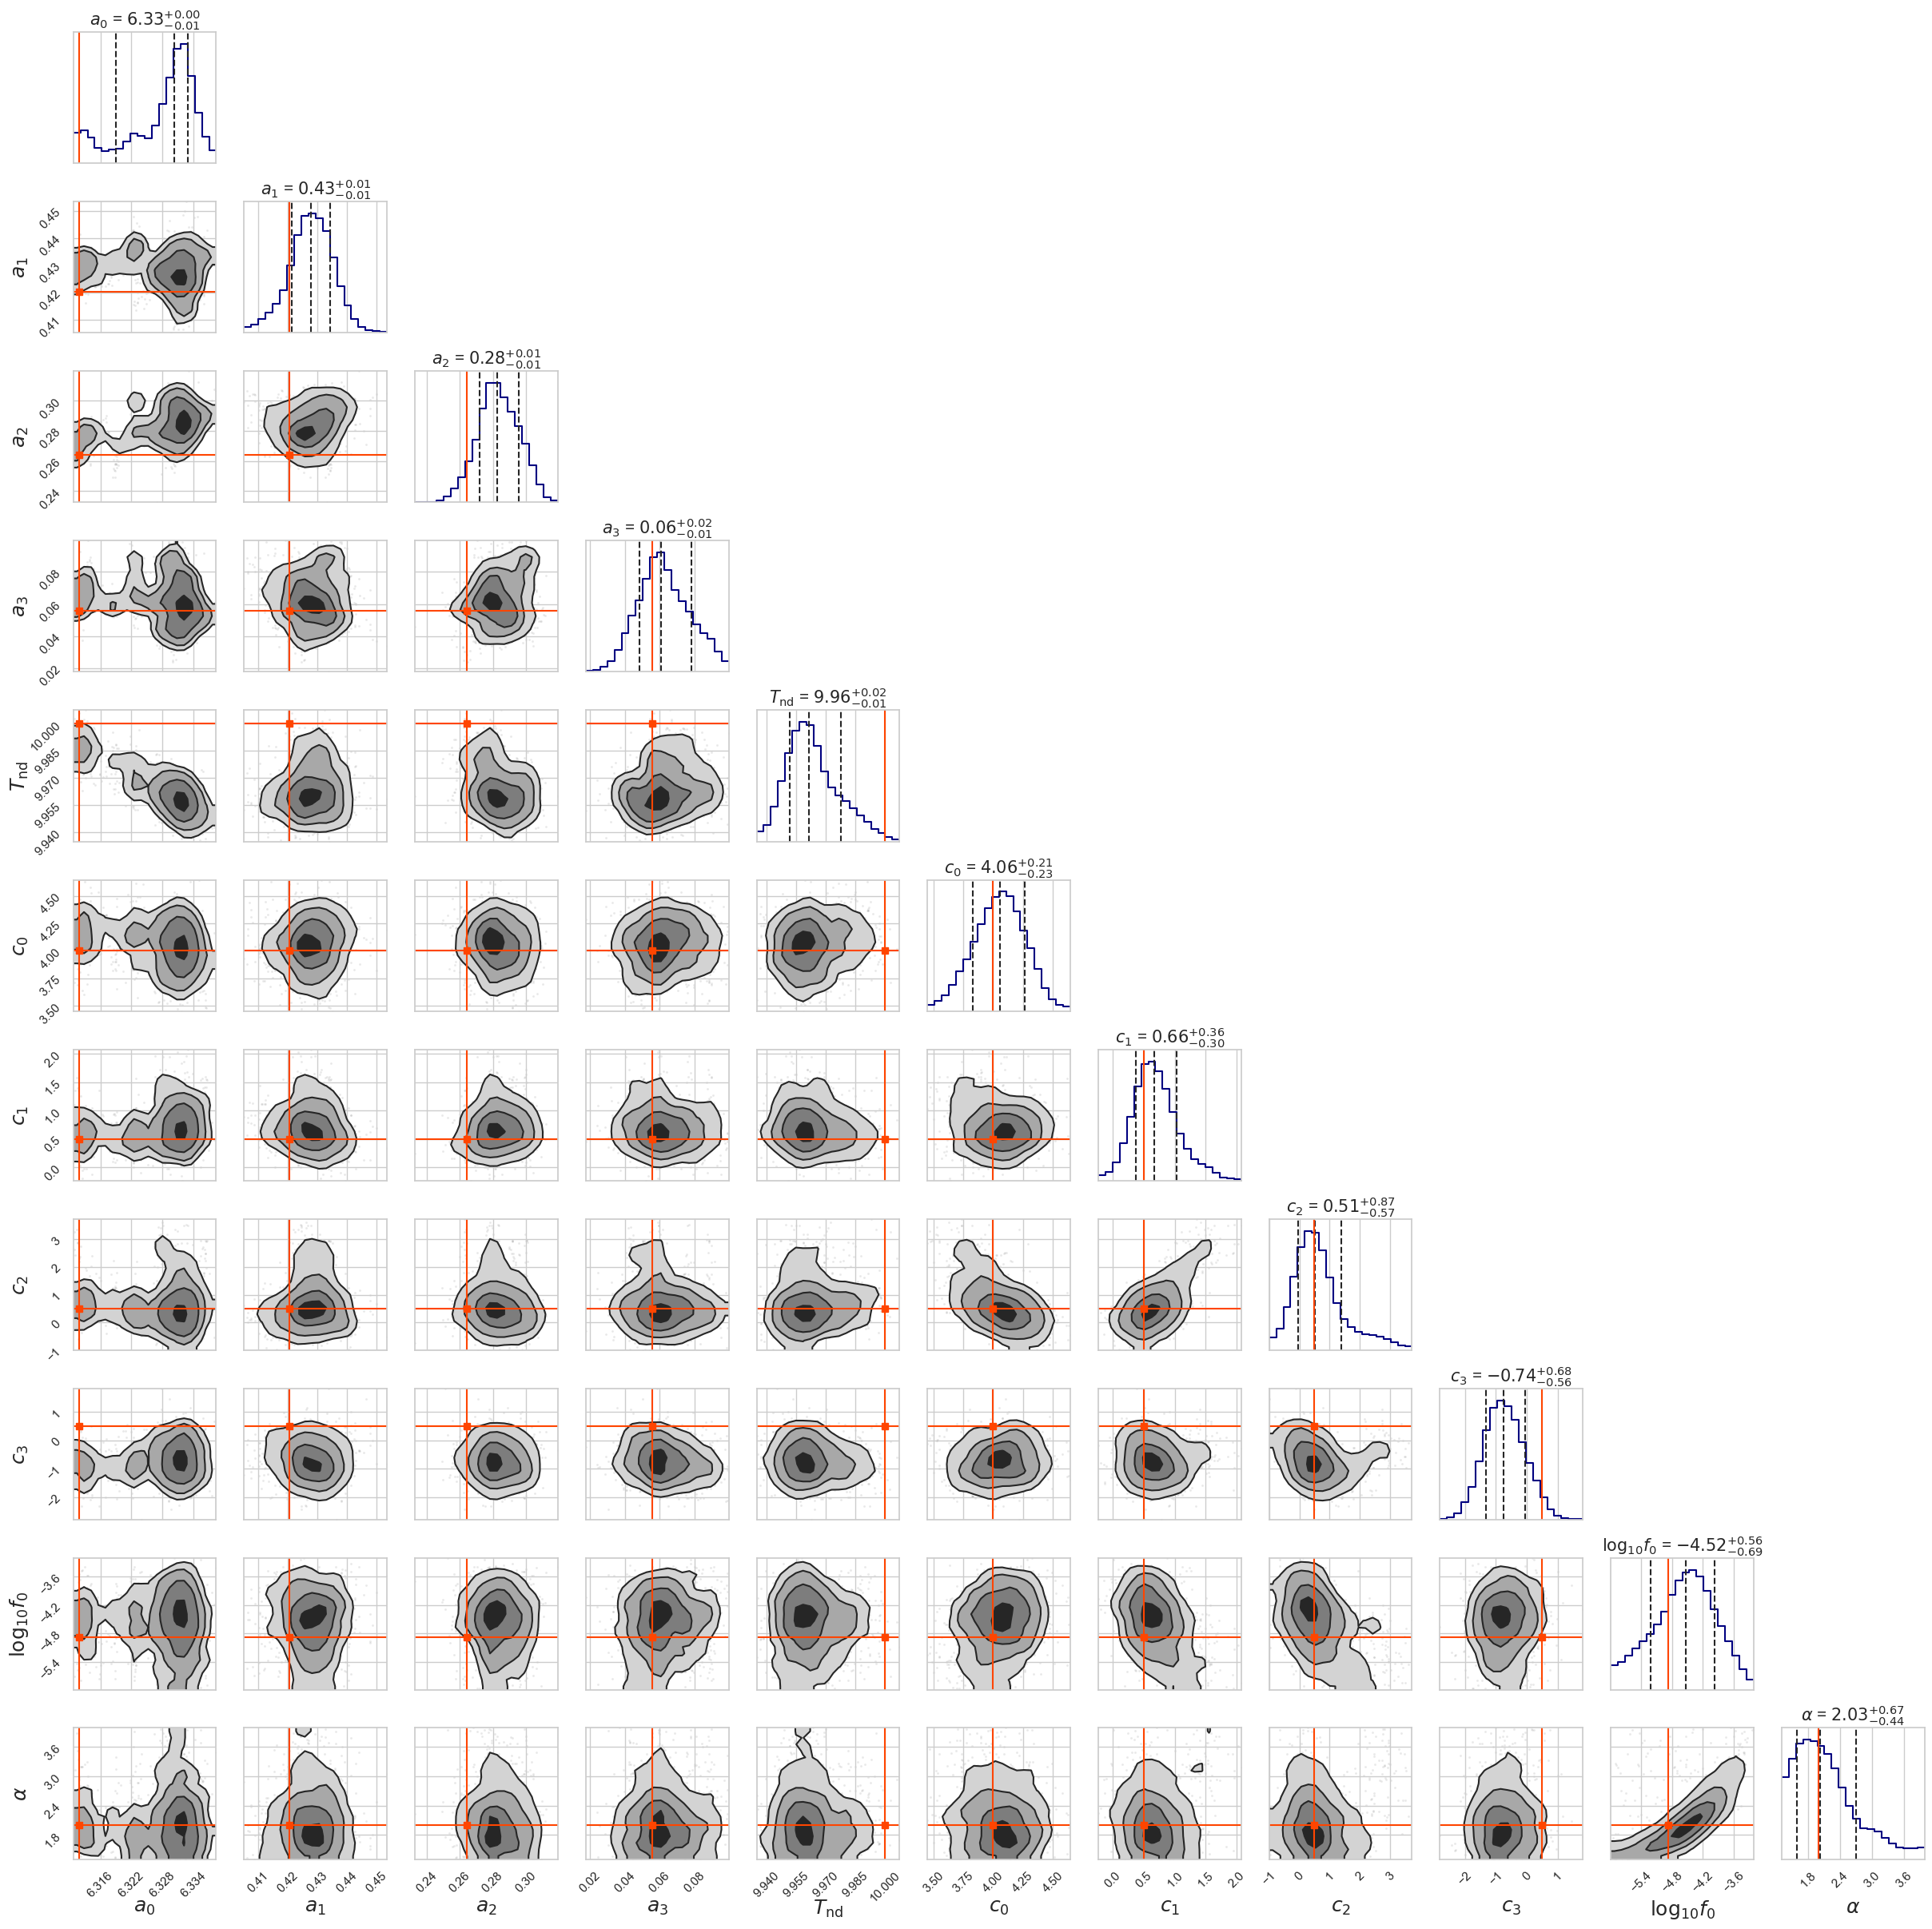

In [21]:
import numpy as np
import corner
import matplotlib.pyplot as plt
 

def plot_corner(samples, labels=[r'$a_0$', r'$a_1$', r'$a_2$',r'$a_3$', r'$T_{\mathrm{nd}}$',
                                r'$c_0$', r'$c_1$', r'$c_2$',r'$c_3$',
                                r'$\text{log}_{10} f_0$',r'$\alpha$'], 
                truths=None, quantiles=[0.16, 0.5, 0.84], 
                show_titles=True, title_kwargs={"fontsize": 15}, 
                label_kwargs={"fontsize": 15}, smooth=1.0, smooth1d=1.0,
                truth_color='orangered', fill_contours=True, 
                hist_kwargs={'color': 'navy'}, 
                save_path=None, **kwargs):
    """
    Generates and optionally saves a corner plot from MCMC samples.

    Parameters:
    -----------
    samples : numpy.ndarray
        The MCMC samples array of shape (n_samples, n_params).
    labels : list of str, optional
        A list of names for the parameters (e.g., ['p1', 'p2', ...]). 
        Defaults to None (corner.py might generate default labels).
    # ... (other parameters as before)
    """
    
    if not isinstance(samples, np.ndarray) or samples.ndim != 2:
        raise ValueError("Input 'samples' must be a 2D NumPy array.")

    if labels is not None and len(labels) != samples.shape[1]:
        raise ValueError(f"Number of labels ({len(labels)}) must match number of parameters in samples ({samples.shape[1]}).")

    figure = corner.corner(
        samples,
        labels=labels, # This is where your list of parameter names goes
        truths=truths,
        quantiles=quantiles,
        show_titles=show_titles,
        title_kwargs=title_kwargs,
        label_kwargs=label_kwargs,
        smooth=smooth,
        smooth1d=smooth1d,
        truth_color=truth_color,
        fill_contours=fill_contours,
        hist_kwargs=hist_kwargs,
        **kwargs
    )

    figure.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Corner plot saved to {save_path}")
        plt.show()
    else:
        plt.show()
        
    return figure

plot_corner(other_samples, truths=truths, label_kwargs={"fontsize": 18}, save_path='./GS1_corner_plot.pdf')

In [22]:
def view_patch_map(map, pixel_indices):
    # Create a new map with just the patch (other pixels set to UNSEEN)
    patch_only_map = np.full(len(map), hp.UNSEEN)
    patch_only_map[pixel_indices] = map[pixel_indices]
    return patch_only_map


In [23]:
# Get pixel coordinates
theta, phi = hp.pix2ang(nside, pixel_indices)
lon, lat = np.degrees(phi), 90 - np.degrees(theta)
lon_center, lat_center = np.median(lon), np.median(lat)

# Calculate appropriate zoom/resolution
patch_size = 100  # Add 20% margin
res = patch_size / 20  # Adjust resolution based on patch size

In [24]:
sky_min = 20
sky_max = 70

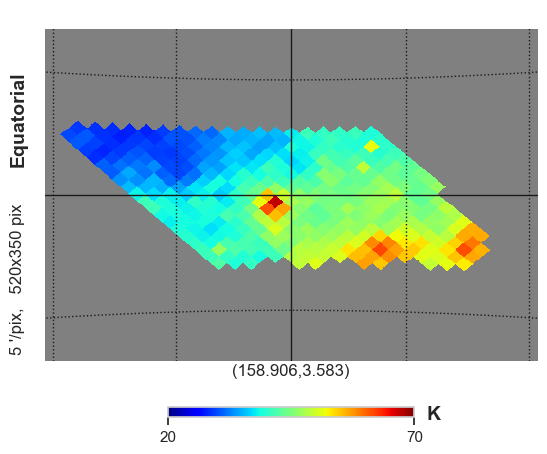

In [25]:
patch_true_map = view_patch_map(true_map, pixel_indices)

hp.gnomview(patch_true_map, rot=(lon_center, lat_center), 
           xsize=520, ysize=350, reso=res, 
           title=" ", 
           unit="K", cmap='jet', min=sky_min, max=sky_max,
           #notext=True,
           coord=['C'], 
           cbar=True, notext=False, badcolor='gray')
#plt.grid(True)
hp.graticule(dpar=10, dmer=10, coord=['C'], local=True)  
#plt.grid(color='gray', linestyle=':', alpha=0.5)  # Custom grid style
plt.gca().set_facecolor('gray')  # Set background to white
plt.savefig('outputs/GS1/true_map.pdf', bbox_inches='tight', 
            pad_inches=0.1)

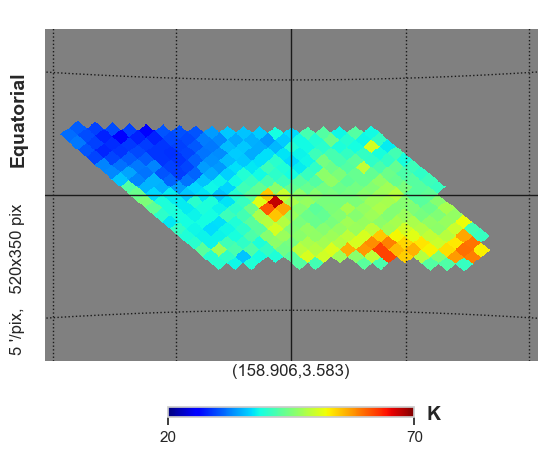

In [26]:
patch_mean_map = view_patch_map(sample_mean_map, pixel_indices)

hp.gnomview(patch_mean_map, rot=(lon_center, lat_center), 
           xsize=520, ysize=350, reso=res, title=" ", 
           unit="K", cmap='jet', min=sky_min, max=sky_max,
           #notext=True,
           coord=['C'], 
           cbar=True, notext=False, badcolor='gray')
#plt.grid(True)
hp.graticule(dpar=10, dmer=10, coord=['C'], local=True)  
#plt.grid(color='gray', linestyle=':', alpha=0.5)  # Custom grid style
plt.gca().set_facecolor('gray')  # Set background to white
plt.savefig("outputs/GS1/mean_map.pdf", bbox_inches='tight', 
            pad_inches=0.1)

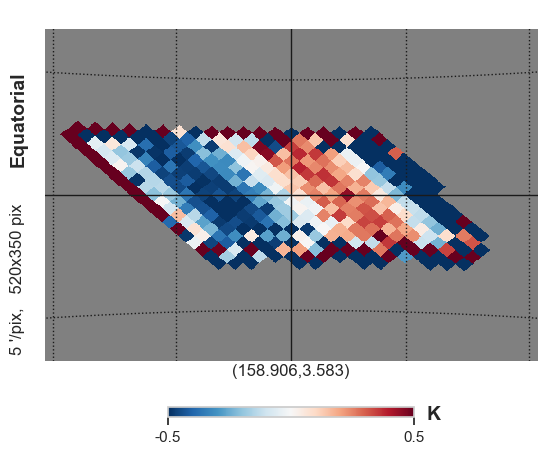

In [27]:
patch_error_map = view_patch_map(sample_mean_map-true_map, pixel_indices)
# plt.figure(figsize=(10, 6))
hp.gnomview(patch_error_map, rot=(lon_center, lat_center), 
           xsize=520, ysize=350, reso=res, title=" ", 
           unit="K", cmap='RdBu_r', min=-0.5, max=0.5,
           #notext=True,
           coord=['C'], 
           cbar=True, notext=False,
           badcolor='gray')
#plt.grid(True)
hp.graticule(dpar=10, dmer=10, coord=['C'], local=True)  
#plt.grid(color='gray', linestyle=':', alpha=0.5)  # Custom grid style
plt.gca().set_facecolor('gray')  # Set background to white
plt.savefig("outputs/GS1/error_map.pdf", bbox_inches='tight', 
            pad_inches=0.1)

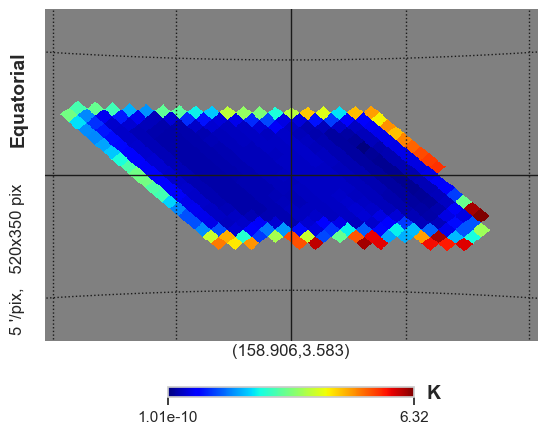

In [28]:
patch_std_map = view_patch_map(sample_std_map, pixel_indices)

hp.gnomview(patch_std_map, rot=(lon_center, lat_center), 
           xsize=520, ysize=350, reso=res, title=None, 
           unit="K", cmap='jet', 
           notext=False,
           coord=['C'], 
           cbar=True, 
           badcolor='gray',
           #sub=(2, 1, 1),  # Proper subplot specification
           #margins=(0.05, 0.15, 0.05, 0.15)
           )
#plt.grid(True)
hp.graticule(dpar=10, dmer=10, coord=['C'], local=True)  
#plt.grid(color='gray', linestyle=':', alpha=0.5)  # Custom grid style
plt.gca().set_facecolor('gray')  # Set background to white
plt.savefig("outputs/GS1/std_map.pdf", bbox_inches='tight', 
            pad_inches=0.1)